In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
# from docs.examples.utils import clean_legend

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.key(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/home/hardik/Desktop/Research/FORESEE/venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 2500
noise = 0.5

key, subkey = jr.split(key)
x1 = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
x2 = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
x = jnp.append(x1, x2, axis=1)
f = lambda x: jnp.sin(2 * x[:,[0]]) + x[:,[1]] * jnp.cos(5 * x[:,[1]])
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest1 = jnp.linspace(-3.1, 3.1, 500).reshape(-1, 1)
xtest2 = jnp.linspace(-3.1, 3.1, 500).reshape(-1, 1)
xtest = jnp.append(xtest1, xtest2, axis=1)
ytest = f(xtest)

In [3]:
y.shape

(2500, 1)

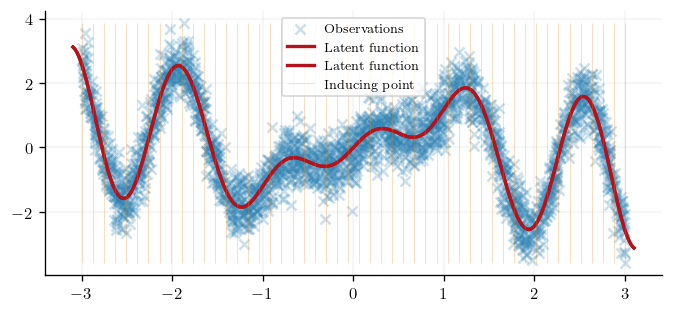

In [4]:
n_inducing = 50
z1 = jnp.linspace(-3.0, 3.0, n_inducing).reshape(-1, 1)
z2 = jnp.linspace(-3.0, 3.0, n_inducing).reshape(-1, 1)
z = jnp.append(z1, z2, axis=1)
fig, ax = plt.subplots()
ax.scatter(x[:,[0]], y, alpha=0.25, label="Observations", color=cols[0])
# ax.scatter(x[:,[1]], y, alpha=0.25, label="Observations", color=cols[2], alpha=0.2)
ax.plot(xtest, ytest, label="Latent function", linewidth=2, color=cols[1])
ax.vlines(
    x=z[:,[0]],
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.3,
    linewidth=0.5,
    label="Inducing point",
    color=cols[2],
)
ax.legend(loc="best")
plt.show()

In [64]:
D.n

2500

In [5]:
meanf = gpx.mean_functions.Constant()
kernel = gpx.kernels.RBF(active_dims=[0,1])
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
posterior = prior * likelihood

In [50]:
q = gpx.variational_families.CollapsedVariationalGaussian(
    posterior=posterior, inducing_inputs=z
)

In [60]:
elbo = gpx.objectives.CollapsedELBO(negative=True)

In [6]:
negative_mll = jit(gpx.objectives.ConjugateMLL(negative=True))

In [52]:
print(gpx.cite(elbo))

@inproceedings{titsias2009variational,
authors = {Titsias, Michalis},
title = {Variational learning of inducing variables in sparse Gaussian processes},
year = {2009},
booktitle = {International Conference on Artificial Intelligence and Statistics},
}


In [41]:
elbo = jit(elbo)

In [53]:
opt_posterior, history = gpx.fit(
    model=q,
    objective=elbo,
    train_data=D,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters=500,
    key=key,
)

Running: 100%|███████████████████████████████████████████| 500/500 [00:06<00:00, 73.77it/s, Value=1854.55]


In [7]:
# full model
opt_posterior_full, history_full = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters=500,
    key=key,
)

Running: 100%|███████████████████████████████████████████| 500/500 [13:43<00:00,  1.65s/it, Value=1924.85]


[Text(0.5, 0, 'Training iterate'), Text(0, 0.5, 'ELBO')]

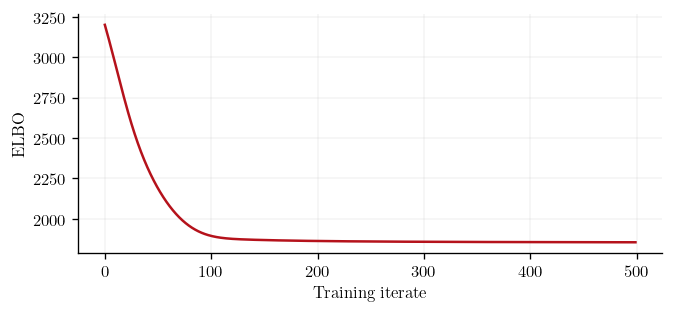

In [54]:
fig, ax = plt.subplots()
ax.plot(history, color=cols[1])
ax.set(xlabel="Training iterate", ylabel="ELBO")

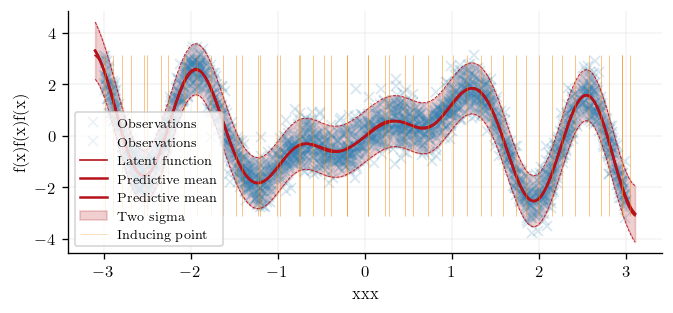

In [56]:
latent_dist = opt_posterior(xtest, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

inducing_points = opt_posterior.inducing_inputs

samples = latent_dist.sample(seed=key, sample_shape=(20,))

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots()

ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.1)
ax.plot(
    xtest[:,0],
    ytest,
    label="Latent function",
    color=cols[1],
    linestyle="-",
    linewidth=1,
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])

ax.fill_between(
    xtest[:,0].squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color=cols[1],
    label="Two sigma",
)
ax.plot(
    xtest[:,0],
    predictive_mean - 2 * predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=0.5,
)
ax.plot(
    xtest[:,0],
    predictive_mean + 2 * predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=0.5,
)


ax.vlines(
    x=inducing_points,
    ymin=ytest.min(),
    ymax=ytest.max(),
    alpha=0.3,
    linewidth=0.5,
    label="Inducing point",
    color=cols[2],
)
ax.legend()
ax.set(xlabel=r"xxx", ylabel=r"f(x)f(x)f(x)")
plt.show()

In [57]:
full_rank_model = gpx.gps.Prior(
    mean_function=gpx.mean_functions.Zero(), kernel=gpx.kernels.RBF()
) * gpx.likelihoods.Gaussian(num_datapoints=D.n)
negative_mll = jit(gpx.objectives.ConjugateMLL(negative=True).step)
%timeit negative_mll(full_rank_model, D).block_until_ready()

269 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
negative_elbo = jit(gpx.objectives.CollapsedELBO(negative=True).step)
%timeit negative_elbo(q, D).block_until_ready()

3.48 ms ± 373 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
%timeit latent_dist = opt_posterior(xtest, train_data=D)

43.1 ms ± 962 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit latent_dist = opt_posterior(xtest, train_data=D)